## **INTRODUÇÃO**

Na atividade desenvolvida nesse notebook, buscou-se implementar o acompanhamento das curvas de aprendizado dos dados de treinamento e validação utilizando da rede neural desenvolvida manualmente em Python ao longo da disciplina. Essa modificação permitiu registrar graficamente a relação entre as perdas obtidas e as épocas, possibilitando a análise do comportamento da rede e sua tendência de queda.

---

## **CÓDIGO**

Importamos as bibliotecas que iremos utilizar:

In [1]:
import random
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

E já definimos as classes, que são as mesmas que implementamos durante a disciplina em Python puro:

In [2]:
class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"
    
    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad
            
        resultado.propagar = propagar_adicao
        
        return resultado
    
    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data # grad_filho * derivada filho em relação a mãe
            outro_valor.grad += resultado.grad * self.data
            
        resultado.propagar = propagar_multiplicacao
        
        return resultado
    
    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = math.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_exp():
            self.grad += resultado.grad * data 
        
        resultado.propagar = propagar_exp
        
        return resultado
    
    def __pow__(self, expoente):
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))
        
        resultado.propagar = propagar_pow
        
        return resultado
    
    def __truediv__(self, outro_valor):
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)
    
    def __neg__(self):
        """Realiza a operação: -self"""
        return self * -1
    
    def __sub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)
    
    def __radd__(self, outro_valor):
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor
    
    def __rmul__(self, outro_valor):
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor
    
    def sig(self):
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        return self.exp() / (self.exp() + 1)
    
    def propagar(self):
        pass
    
    def propagar_tudo(self):
        
        self.grad = 1
        
        ordem_topologica = []
        
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)
        
        for vertice in reversed(ordem_topologica):
            vertice.propagar()

In [3]:
class Neuronio:
    def __init__(self, num_dados_entrada):
        self.vies = Valor(random.uniform(-1, 1))
        
        self.pesos = []
        for i in range(num_dados_entrada):
            self.pesos.append(Valor(random.uniform(-1, 1)))
            
    def __call__(self, x):
        
        assert len(x) == len(self.pesos)
        
        soma = 0
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno
            
        soma += self.vies  
        dado_de_saida = soma.sig()
        
        return dado_de_saida       
    
    def parametros(self):
        return self.pesos + [self.vies]

In [4]:
class Camada:
    def __init__(self, num_neuronios, num_dados_entrada):
        neuronios = []
        
        for _ in range(num_neuronios):
            neuronio = Neuronio(num_dados_entrada)
            neuronios.append(neuronio)
            
        self.neuronios = neuronios     
        
    def __call__(self, x):
        dados_de_saida = []
        
        for neuronio in self.neuronios:
            informacao = neuronio(x)
            dados_de_saida.append(informacao)
            
        if len(dados_de_saida) == 1:
            return dados_de_saida[0]
        else:        
            return dados_de_saida  
    
    def parametros(self):
        params = []
        
        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio)
        
        return params

In [5]:
class MLP:
    def __init__(self, num_dados_entrada, num_neuronios_por_camada):
        
        percurso = [num_dados_entrada] + num_neuronios_por_camada
        
        camadas = []
        
        for i in range(len(num_neuronios_por_camada)):
            camada = Camada(num_neuronios_por_camada[i], percurso[i])
            camadas.append(camada)
            
        self.camadas = camadas
        
    def __call__(self, x):
        for camada in self.camadas:
            x = camada(x)
        return x
    
    def parametros(self):
        params = []
        
        for camada in self.camadas:
            parametros_camada = camada.parametros()
            params.extend(parametros_camada)
            
        return params

E, para utilizar com a rede, importamos nossos dados. Nesse caso, vamos de dataset de flores ("iris", da biblioteca *Seaborn*):

In [6]:
df = sns.load_dataset('iris')
df = df.dropna()
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


Definimos os atributos e o target do modelo:

In [7]:
atributos = list(df.columns)[:3] 
target = [list(df.columns)[-2]]

In [8]:
atributos

['sepal_length', 'sepal_width', 'petal_length']

In [9]:
target

['petal_width']

Dividimos o modelo para entender quais são os seus dados de treino, teste e validação:

In [10]:
TAMANHO_TESTE = 0.1
TAMANHO_VALIDACAO = 0.1
TAMANHO_TREINO = 1 - TAMANHO_TESTE - TAMANHO_VALIDACAO
TAMANHO_TREINO, TAMANHO_VALIDACAO, TAMANHO_TESTE
SEMENTE_ALEATORIA = 8

In [11]:
indices = df.index
indices_treino_val, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino_val = df.loc[indices_treino_val]
df_teste = df.loc[indices_teste]

X_teste = df_teste.reindex(atributos, axis=1).values
y_teste = df_teste.reindex(atributos, axis=1).values

In [12]:
df_teste

,sepal_length,sepal_width,petal_length,petal_width,species
4,5.0,3.6,1.4,0.2,setosa
29,4.7,3.2,1.6,0.2,setosa
27,5.2,3.5,1.5,0.2,setosa
141,6.9,3.1,5.1,2.3,virginica
65,6.7,3.1,4.4,1.4,versicolor
34,4.9,3.1,1.5,0.2,setosa
23,5.1,3.3,1.7,0.5,setosa
145,6.7,3.0,5.2,2.3,virginica
132,6.4,2.8,5.6,2.2,virginica
74,6.4,2.9,4.3,1.3,versicolor


In [13]:
indices = df_treino_val.index
indices_treino, indices_val = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino = df.loc[indices_treino]
df_val = df.loc[indices_val]

X_treino = df_treino.reindex(atributos, axis=1).values
y_treino = df_treino.reindex(target, axis=1).values

X_val = df_val.reindex(atributos, axis=1).values
y_val = df_val.reindex(target, axis=1).values

In [14]:
df_treino

,sepal_length,sepal_width,petal_length,petal_width,species
24,4.8,3.4,1.9,0.2,setosa
135,7.7,3.0,6.1,2.3,virginica
70,5.9,3.2,4.8,1.8,versicolor
3,4.6,3.1,1.5,0.2,setosa
128,6.4,2.8,5.6,2.1,virginica
...,...,...,...,...,...
138,6.0,3.0,4.8,1.8,virginica
26,5.0,3.4,1.6,0.4,setosa
95,5.7,3.0,4.2,1.2,versicolor
148,6.2,3.4,5.4,2.3,virginica


In [15]:
df_val

,sepal_length,sepal_width,petal_length,petal_width,species
105,7.6,3.0,6.6,2.1,virginica
129,7.2,3.0,5.8,1.6,virginica
88,5.6,3.0,4.1,1.3,versicolor
49,5.0,3.3,1.4,0.2,setosa
118,7.7,2.6,6.9,2.3,virginica
139,6.9,3.1,5.4,2.1,virginica
149,5.9,3.0,5.1,1.8,virginica
122,7.7,2.8,6.7,2.0,virginica
13,4.3,3.0,1.1,0.1,setosa
85,6.0,3.4,4.5,1.6,versicolor


Definimos a arquitetura:

In [16]:
NUM_DADOS_DE_ENTRADA = 3  
NUM_DADOS_DE_SAIDA = 1    
CAMADAS_OCULTAS = [3, 2]  

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]

minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede)

E fazemos novamente nosso treinamento por épocas utilizando dos dados de treino e validação:

In [17]:
NUM_EPOCAS = 200
TAXA_DE_APRENDIZADO = 0.1

dados_perda_treino = []
dados_perda_validacao = []

for epoca in range(NUM_EPOCAS):
    # forward pass do treino
    y_pred_treino = []
    for exemplo in X_treino:
        previsao = minha_mlp(exemplo)
        y_pred_treino.append(previsao)

    # loss do treino
    erros_treino = []
    for yt, yp in zip(y_treino, y_pred_treino):
        residuo = yp - yt
        erro_quadratico = residuo ** 2
        erros_treino.append(erro_quadratico)        
    loss_treino = sum(erros_treino)
    dados_perda_treino.append(loss_treino.data)

    # forward pass da validação
    y_pred_val = []
    for exemplo in X_val:
        previsao = minha_mlp(exemplo)
        y_pred_val.append(previsao)

    # loss da validação
    erros_val = []
    for yt, yp in zip(y_val, y_pred_val):
        residuo = yp - yt
        erro_quadratico = residuo ** 2
        erros_val.append(erro_quadratico)
    loss_val = sum(erros_val)
    dados_perda_validacao.append(loss_val.data)

    # zero grad
    for p in minha_mlp.parametros():
        p.grad = 0

    # backpropagation
    loss_treino.propagar_tudo()

    # atualiza parâmetros
    for p in minha_mlp.parametros():
        p.data = p.data - p.grad * TAXA_DE_APRENDIZADO

    # mostra resultado (opcional)
    print(epoca, "|" , f"Loss Treino:{loss_treino.data}", "|", f"Loss Validação:{loss_val.data}")

0 | Loss Treino:[117.99871685] | Loss Validação:[18.45197654]
1 | Loss Treino:[72.06971151] | Loss Validação:[10.75364285]
2 | Loss Treino:[72.06901807] | Loss Validação:[10.75348479]


C:\Users\caio24034\AppData\Local\Temp\ipykernel_19324\1580685315.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data = math.exp(self.data)


3 | Loss Treino:[72.06833961] | Loss Validação:[10.75333014]
4 | Loss Treino:[72.06767568] | Loss Validação:[10.75317879]
5 | Loss Treino:[72.06702581] | Loss Validação:[10.75303064]
6 | Loss Treino:[72.06638958] | Loss Validação:[10.7528856]
7 | Loss Treino:[72.06576656] | Loss Validação:[10.75274356]
8 | Loss Treino:[72.06515635] | Loss Validação:[10.75260444]
9 | Loss Treino:[72.06455858] | Loss Validação:[10.75246814]
10 | Loss Treino:[72.06397286] | Loss Validação:[10.7523346]
11 | Loss Treino:[72.06339885] | Loss Validação:[10.75220371]
12 | Loss Treino:[72.06283621] | Loss Validação:[10.75207541]
13 | Loss Treino:[72.0622846] | Loss Validação:[10.75194963]
14 | Loss Treino:[72.0617437] | Loss Validação:[10.75182628]
15 | Loss Treino:[72.06121323] | Loss Validação:[10.75170531]
16 | Loss Treino:[72.06069287] | Loss Validação:[10.75158664]
17 | Loss Treino:[72.06018236] | Loss Validação:[10.75147021]
18 | Loss Treino:[72.05968141] | Loss Validação:[10.75135596]
19 | Loss Treino:[7

E aí sim plotamos a nossa curva de aprendizado a partir da perda por época:

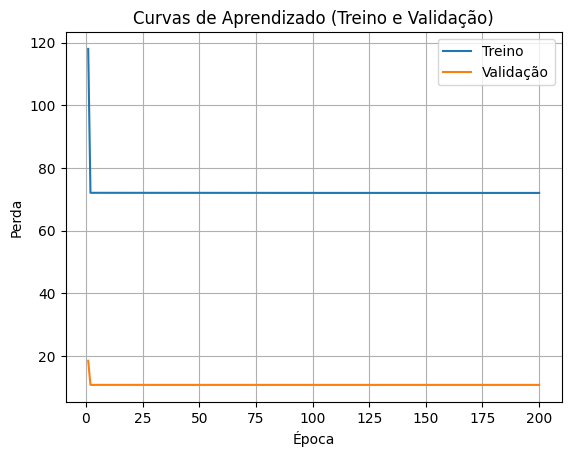

In [18]:
plt.plot(range(1, NUM_EPOCAS + 1), dados_perda_treino, label='Treino')
plt.plot(range(1, NUM_EPOCAS + 1), dados_perda_validacao, label='Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Curvas de Aprendizado (Treino e Validação)')
plt.legend()
plt.grid(True)
plt.show()

Só que, nesse caso, vemos um gráfico um tanto diferente...

Podemos perceber, olhando pros prints da perda de cada época, que a primeira época possui uma perda muito discrepante das outras, mas posteriormente há sim um aprendizado da rede que não consegue ser visto graficamente por causa da escala. 

Com isso em mente, faremos também uma análise gráfica do aprendizado de cada conjunto de dados separados (para não termos problemas com escala de novo) sem analisar a primeira época e ver se realmente o modelo está aprendendo:

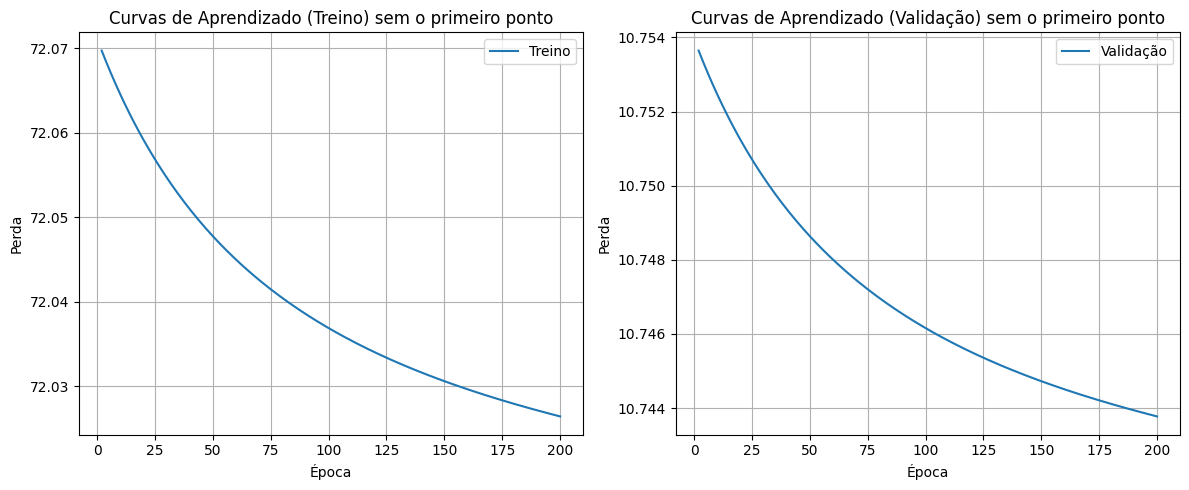

In [19]:
plt.figure(figsize=(12, 5)) 

plt.subplot(1, 2, 1)
plt.plot(range(2, NUM_EPOCAS + 1), dados_perda_treino[1:], label='Treino')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Curvas de Aprendizado (Treino) sem o primeiro ponto')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(2, NUM_EPOCAS + 1), dados_perda_validacao[1:], label='Validação')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Curvas de Aprendizado (Validação) sem o primeiro ponto')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

---

## **CONCLUSÃO**

A implementação do registro das curvas de aprendizado permitiu visualizar, de forma clara, como o modelo evolui ao longo das épocas de treinamento, tanto no conjunto de treino quanto no de validação. Além disso, a atividade reforçou a importância de acompanhar o desempenho da rede durante o aprendizado, auxiliando na identificação de possíveis problemas no modelo.

---

## **REFERÊNCIAS**

**[1]** CASSAR, Daniel. Redes Neurais e Algoritmos Genéticos. 2025. Material de Aula.